# Clustering and differential expression analysis of PBMC2 using scVI-tools

In [8]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scvi
import os

In [9]:
num_of_clusters = 16 # should be 16 for PBMC2

tool_name = 'scvi-tools'
dataset_name = 'PBMC2'
data_path = '../../dataset/{}-Filtered/10x/'.format(dataset_name)
save_path = '../../results/{}/{}/'.format(dataset_name, tool_name)

if not os.path.exists(save_path):
    os.makedirs(save_path)

## Data loading and preparation

Dataset loading 

In [10]:
adata = sc.read_10x_mtx(
    data_path,
    var_names='gene_symbols',
    cache=False
)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 6019 × 13707
    var: 'gene_ids'

Studying feature variance

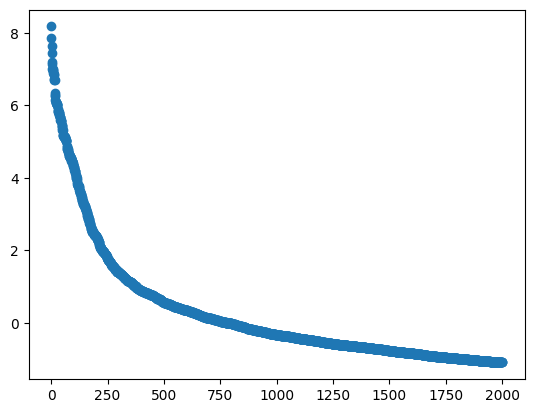

In [11]:
matrix = adata.X
matrix = matrix.todense()
neg_variances = np.sort(-np.var(matrix, axis=0))
sorted_log_variances = [np.log(-i) for i in neg_variances.T][:2000]
plt.scatter([i for i in range(len(sorted_log_variances))], sorted_log_variances)

Data normalization

In [12]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

Feature selection

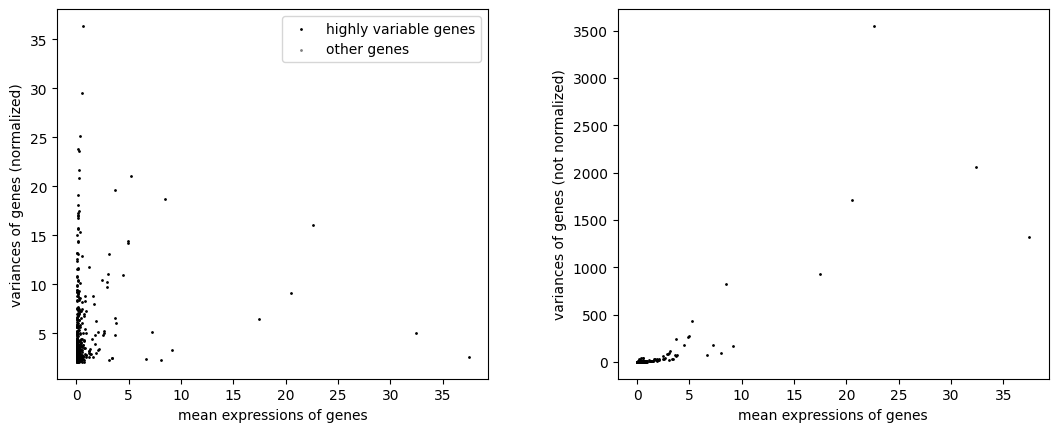

In [13]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=400, # chosen based on elbow plot above
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)
sc.pl.highly_variable_genes(adata)

In [7]:
#sc.pp.scale(adata, max_value=10) # FIXME: not done in scivi-tools tutorial, done in scanpy

## Model training

In [14]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts", # FIXME: need to specify other params?
    n_latent=
)

model = scvi.model.SCVI(adata)
model.train(use_gpu=False)
model.save('./models/{}/'.format(dataset_name), overwrite=True)

model

/home/matteo/miniconda3/envs/cotan/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/home/matteo/miniconda3/envs/cotan/lib/python3.11/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 400/400: 100%|██████████| 400/400 [03:05<00:00,  2.15it/s, v_num=1, train_loss_step=149, train_loss_epoch=143]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:05<00:00,  2.15it/s, v_num=1, train_loss_step=149, train_loss_epoch=143]


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

## Clustering

Save latent representation

In [15]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent
adata.layers["scvi_normalized"] = model.get_normalized_expression() # FIXME: really needed?

Plot pca explained variance ratio to choose number of components

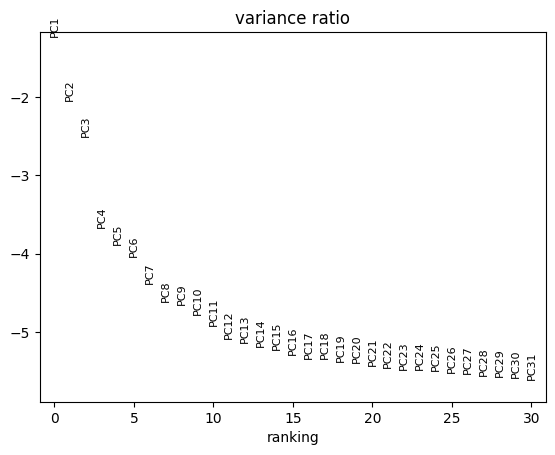

In [18]:
sc.tl.pca(adata, svd_solver="arpack", n_comps=100, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

Perform the clustering

In [20]:
sc.pp.neighbors(
    adata,
    # n_pcs=11, # chosen based on elbow plot above
    #n_neighbors=20, # FIXME: how to choose this? default is 15, 20 in the tutorial (heart cell atlas)
                    # it is the number of nearest neighbors to be searched
                    # "Larger values result in more global views of the manifold,
                    #  while smaller values result in more local data being preserved"
    use_rep="X_scVI"
)
res = 0.000
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=res)
while not (adata.obs.leiden_scVI.values.categories.values).shape == (num_of_clusters,):
    print(f"Clustering with resolution={res}...")
    res += 0.005
    sc.tl.leiden(adata, key_added="leiden_scVI", resolution=res)

Clustering with resolution=0.0...
Clustering with resolution=0.005...
Clustering with resolution=0.01...
Clustering with resolution=0.015...
Clustering with resolution=0.02...
Clustering with resolution=0.025...
Clustering with resolution=0.030000000000000002...
Clustering with resolution=0.035...
Clustering with resolution=0.04...
Clustering with resolution=0.045...
Clustering with resolution=0.049999999999999996...
Clustering with resolution=0.05499999999999999...
Clustering with resolution=0.05999999999999999...
Clustering with resolution=0.06499999999999999...
Clustering with resolution=0.06999999999999999...
Clustering with resolution=0.075...
Clustering with resolution=0.08...
Clustering with resolution=0.085...
Clustering with resolution=0.09000000000000001...
Clustering with resolution=0.09500000000000001...
Clustering with resolution=0.10000000000000002...
Clustering with resolution=0.10500000000000002...
Clustering with resolution=0.11000000000000003...
Clustering with resolu

Visualize the clustering in the PCA space

/home/matteo/miniconda3/envs/cotan/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/matteo/miniconda3/envs/cotan/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


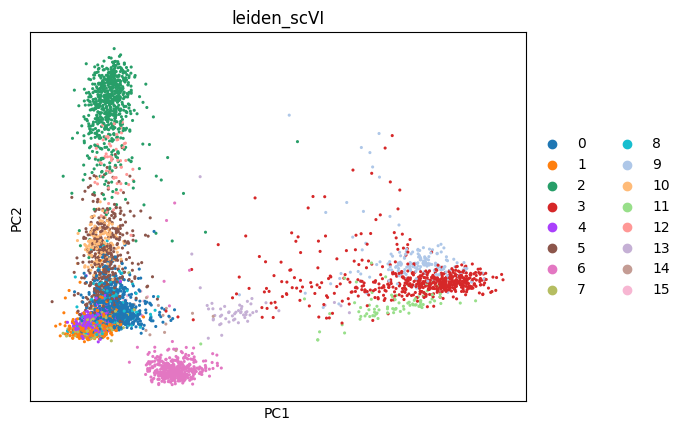

In [21]:
sc.pl.pca(
    adata,
    color=["leiden_scVI"],
    size=20,
)

Save the clustering results

In [22]:
df = pd.DataFrame(adata.obs['leiden_scVI'])
labels = df.rename(columns={'leiden_scVI': 'cluster'})
labels.index.names = ['cell']
labels['cluster'] = labels['cluster'].astype(int) + 1
labels.to_csv(save_path+'clustering_labels.csv')

## Differential expression

In [16]:
# sc.tl.rank_genes_groups(adata, 'leiden_scVI', method='wilcoxon') # FIXME: really needed?

Perform the differential expression analysis

In [23]:
de_df = model.differential_expression(
    groupby="leiden_scVI",
)

DE...: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]


Save markers

In [29]:
number_of_markers = 400
markers = {}
cats = adata.obs.leiden_scVI.cat.categories
for i, c in enumerate(cats):
    cell_type_df = de_df.loc[de_df.group1 == c]
    #cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0] # FIXME: was missing, done in the tutorial but does not seem necessary
    # cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 0] # FIXME: set to 3 in the tutorial, if 1 there are not enough markers
    #cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1] # FIXME: there are not enough markers
    markers[c] = cell_type_df.sort_values('lfc_mean', ascending=False).index.tolist()[:number_of_markers]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])
for i in range(num_of_clusters):
    to_add = [ [markers[str(i)][j], i, j] for j in range(number_of_markers)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)

df['cluster'] += 1
df['rank'] += 1
df.to_csv(save_path+'markers.csv', index=False)
